In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt
import heatmap

data = xr.open_dataset("data/delhi_cpcb_2022.nc")
# data = xr.open_dataset("delhi_cpcb_2022.nc")
# data = pd.read_csv("../data/final_data.csv.gz")
data

<xarray.Dataset>
Dimensions:    (station: 40, time: 8783)
Coordinates:
  * station    (station) object 'Alipur, Delhi - DPCC' ... 'Wazirpur, Delhi -...
  * time       (time) datetime64[ns] 2022-01-01T00:30:00 ... 2023-01-01T22:23:30
    latitude   (station) float64 ...
    longitude  (station) float64 ...
Data variables: (12/21)
    From Date  (station, time) datetime64[ns] ...
    To Date    (station, time) datetime64[ns] ...
    PM2.5      (station, time) float64 ...
    PM10       (station, time) float64 ...
    NO         (station, time) float64 ...
    NO2        (station, time) float64 ...
    ...         ...
    WD         (station, time) float64 ...
    SR         (station, time) float64 ...
    BP         (station, time) float64 ...
    AT         (station, time) float64 ...
    RF         (station, time) float64 ...
    TOT-RF     (station, time) float64 ...

In [2]:
df_ = data.to_dataframe().reset_index()
# df_ = 
df = df_[df_["time"]=="2022-03-01 01:30:00"]
df = df.dropna(subset=["PM2.5"])
df = df.rename(columns={"RH": "relative_humidity", "WS": "wind_speed", "WD": "wind_direction", "SR": "solar_radiation", "BP": "pressure", "AT": "temperature", "RF": "rain_fall", "TOT-RF": "total_rainfall"})

In [3]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

def idw(X_train, y_train, X_test):
    k_range = list(range(1, 10))
    param_grid = dict(n_neighbors=k_range)
    knn_model = KNeighborsRegressor(weights = 'distance')
    grid = GridSearchCV(knn_model, param_grid, cv=10, scoring='neg_root_mean_squared_error', return_train_score=False,verbose=0)
    grid_search=grid.fit(X_train, y_train)
#     knn_model.fit(X_train, y_train)
    
    knn_preds = grid_search.predict(X_test)
#     knn_preds = knn_model.predict(X_test)
    
    return knn_preds
    

2022-01-01 00:30:00	82.76884267173561


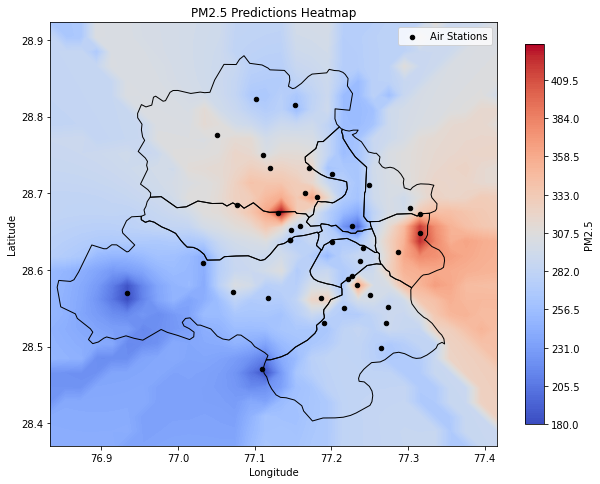

2022-02-01 00:30:00	44.74821707523906


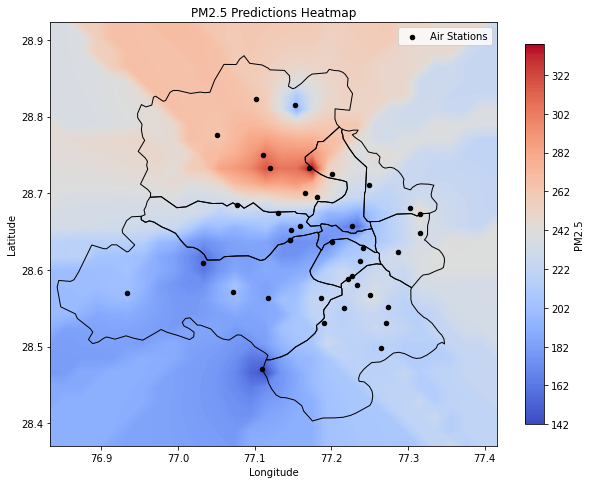

2022-03-01 00:30:00	26.365708630171042


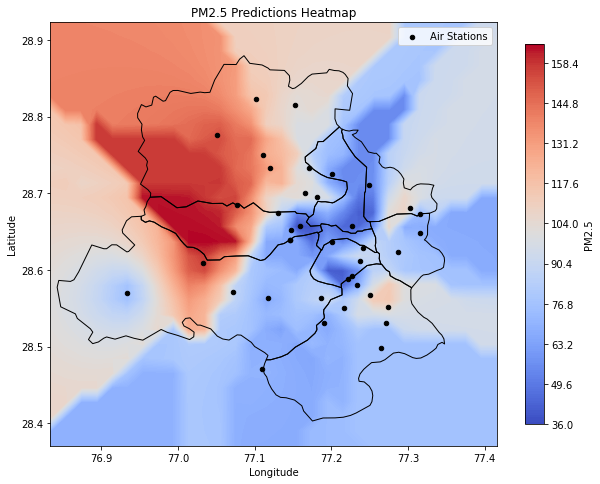

2022-04-01 00:30:00	28.277672778729826


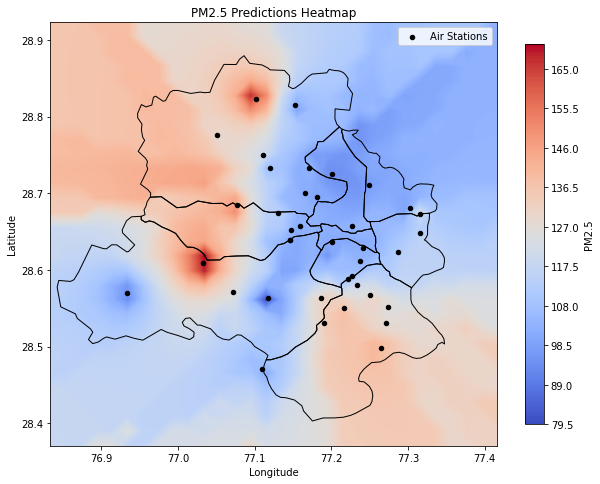

2022-05-01 00:30:00	38.53062612045517


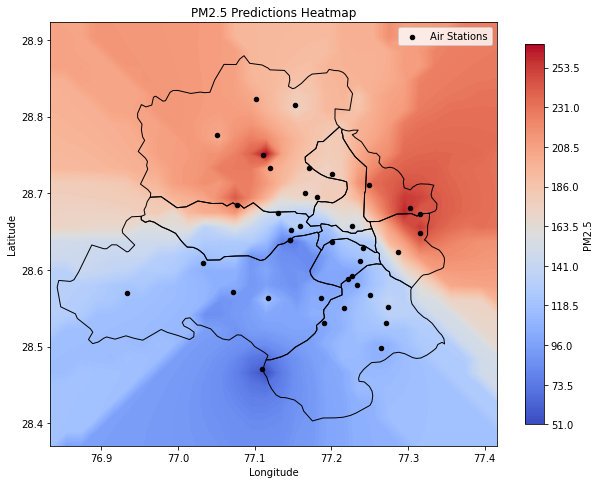

2022-06-01 00:30:00	38.01086959870825


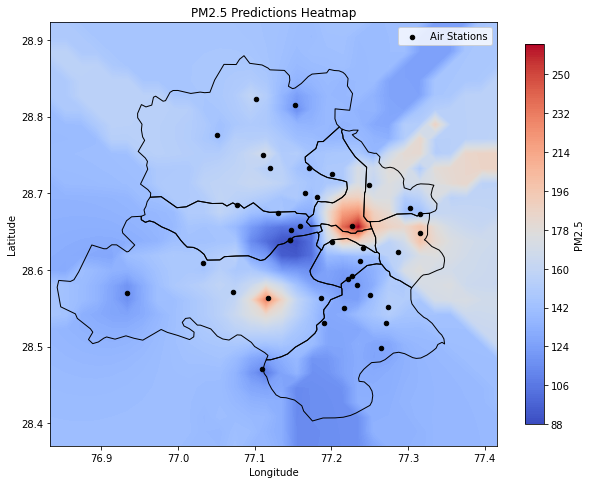

2022-07-01 00:30:00	8.158293251321744


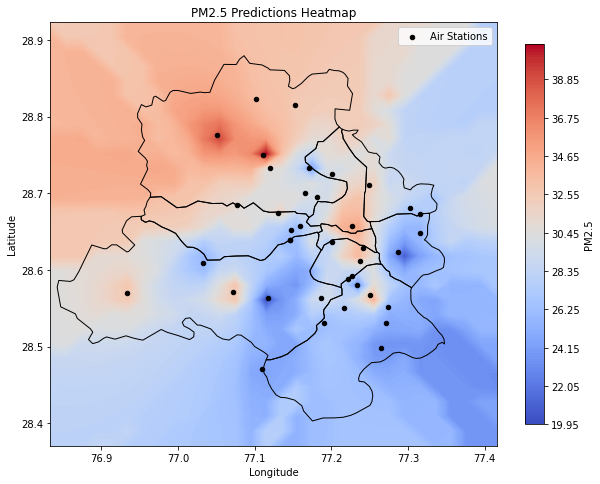

2022-08-01 00:30:00	11.651696050563377


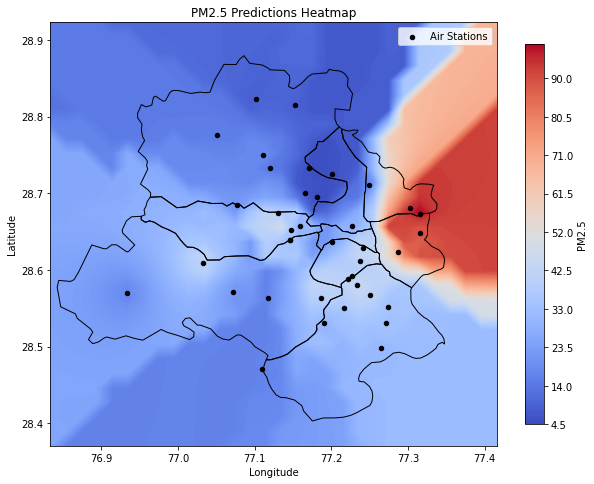

2022-09-01 00:30:00	13.374019814971511


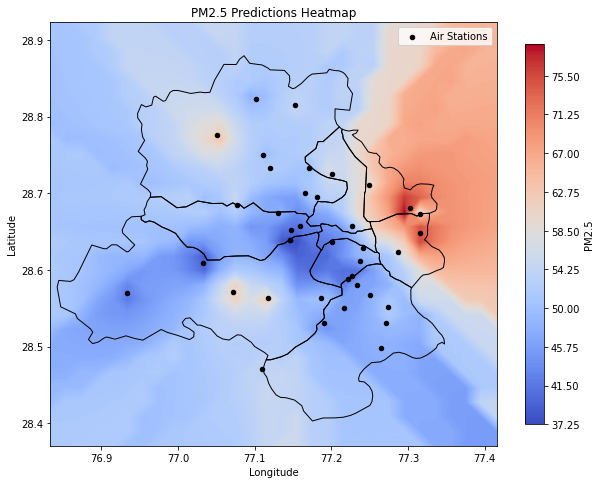

2022-10-01 00:30:00	19.651173948305544


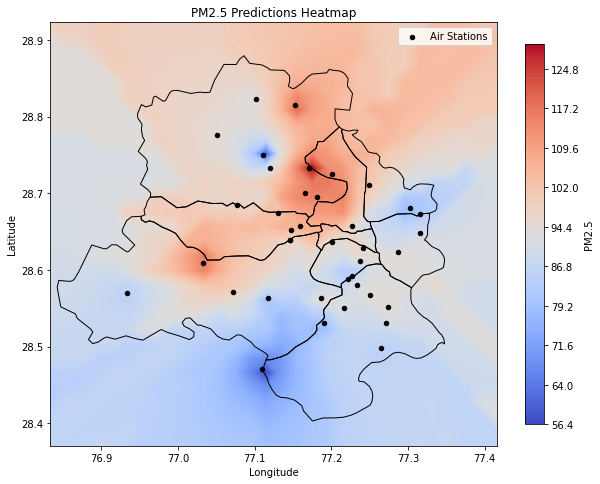

2022-11-01 00:30:00	97.36975278543164


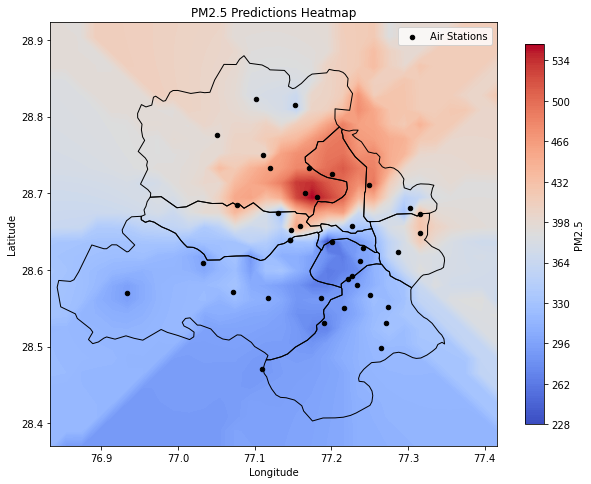

2022-12-01 00:30:00	53.084319286998905


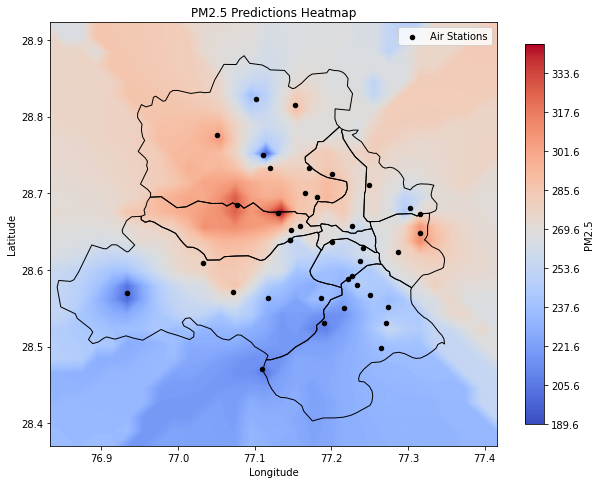

In [4]:
p = pd.date_range(start='2022-01-01 00:30:00', end='2022-12-01 00:30:00', freq = '1MS').to_frame(name='dates')
idw_rmse = []
idw_preds = []

for i in p['dates']:
    df = df_[df_["time"]==i]
    df = df.dropna(subset=["PM2.5"])
    print(i, end = '\t')
    idw_rmse_i = []
    
    #Leave One Out Cross Validation
    for station in df.station.unique():
        train = df[df['station'] != station]
        test = df[df['station'] == station]
        X_train = train[['latitude', 'longitude']]
        X_test = test[['latitude', 'longitude']]
        y_train = train['PM2.5']
        y_test = test['PM2.5']
        pred = idw(X_train, y_train, X_test)
        idw_rmse_i.append(np.sqrt((y_test - pred)**2))
    
    #RMSE
    idw_rmse.append(np.mean(idw_rmse_i))
    print(idw_rmse[-1])
    
    #Heatmap
    latitudes = np.array(df['latitude'])
    longitudes = np.array(df['longitude'])
    g_lat = np.linspace(latitudes.min()-0.1, latitudes.max()+0.1, 30)
    g_long = np.linspace(longitudes.min()-0.1, longitudes.max()+0.1, 30)
    lat_grid, lon_grid = np.meshgrid(g_lat, g_long)
    
    train = df[['latitude', 'longitude', 'PM2.5']]
    test = pd.DataFrame({'longitude':lon_grid.flatten(),
                     'latitude':lat_grid.flatten()})
    
    X_train = train[['latitude', 'longitude']]
    y_train = train['PM2.5']
    X_test = test[['latitude', 'longitude']]
    
    preds = idw(X_train, y_train, X_test)
    test['PM2.5'] = preds
    heatmap.plot_heatmap(lon = np.array(test['longitude']), lat = np.array(test['latitude']), values = test['PM2.5'].values)

In [5]:
idw_rmse

[82.76884267173561,
 44.74821707523906,
 26.365708630171042,
 28.277672778729826,
 38.53062612045517,
 38.01086959870825,
 8.158293251321744,
 11.651696050563377,
 13.374019814971511,
 19.651173948305544,
 97.36975278543164,
 53.084319286998905]